# COVID-19 Trend Analysis
By Tobias Kächele (http://tobiaskaechele.de)

## Constants

In [77]:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
DATA_FILENAME = 'time_series_covid19_confirmed_global.csv'

OUTPUT_DIR_KEY = 'output'
DATA_DIR_KEY = 'data'

DIRPATHS = {
    OUTPUT_DIR_KEY: './output/',
    DATA_DIR_KEY: './data/',
}

COUNTRIES_FOR_REPORT = ['Czechia', 'US', 'Canada', 'France', 'Germany', 'Sweden', 'Netherlands', 'Italy', 
                        'United Kingdom', 'Spain', 'Denmark', 'Poland', 'Austria', 'Switzerland']

BLUE = '#18C4E9'
GRAY = '#555566'
RED  = '#FF1050'

## Helper Functions & Imports

In [78]:
import os
import io
import re
import datetime
import base64
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.ssl_ import create_urllib3_context
from urllib.parse import urlparse, urljoin
from IPython.display import HTML, IFrame


def get_filepath(dir_key, filename, extension=None):
    dirpath = DIRPATHS[dir_key]
    filename_with_extension = filename if extension is None else filename + "." + extension
    return os.path.join(dirpath, filename_with_extension)


def get_data_filepath():
    return get_filepath(DATA_DIR_KEY, DATA_FILENAME)


def get_output_filepath(filename, extension=None):
    return get_filepath(OUTPUT_DIR_KEY, filename, extension)


def convert_title_to_filename(title):
    return re.sub(r'[^a-z0-9_-]+', '_', title.lower())


def convert_title_to_markdown(title):
    illegal_chars = """'"[](){}\\"""
    return ''.join([char for char in title if char not in illegal_chars])


def generate_markdown_for_image(title, url):
    sanitized_title = convert_title_to_markdown(title)
    return f"""![{sanitized_title}]({url} "{sanitized_title}")"""

    
def export_for_plotly(df, filename, keep_index=False):
    filepath = get_output_filepath(filename, 'csv')
    df.to_csv(filepath, date_format="%Y-%m-%d", index=keep_index)
    filepath_excel = get_output_filepath(filename, 'xlsx')
    df.to_excel(filepath_excel, index=keep_index)

## Creation of Folders

In [79]:
for dirpath in DIRPATHS.values():
    if not os.path.isdir(dirpath):
        os.makedirs(dirpath)

## Download of CSV File From GitHub

In [80]:
class SSLContextAdapter(HTTPAdapter):
    def init_poolmanager(self, *args, **kwargs):
        context = create_urllib3_context()
        kwargs['ssl_context'] = context
        context.load_default_certs()
        return super(SSLContextAdapter, self).init_poolmanager(*args, **kwargs)


def download_file_via_ssl(url, *args, **kwargs):
    fragments = urlparse(url)
    host = f"{fragments.scheme}://{fragments.netloc}"
    
    with requests.Session() as s:
        adapter = SSLContextAdapter()
        s.mount(host, adapter)
        response = s.get(url, **kwargs)
        if response.status_code == requests.codes.ok:
            return response.content
        else:
            raise f"Couldn't download file. Response code {response.status_code}"


def download_and_save(url, output_path):
    content = download_file_via_ssl(url)
    with open(output_path, 'wb') as f:
        f.write(content)
    

download_and_save(URL, get_data_filepath())

## Loading CSV via Pandas

In [81]:
raw_dataset = pd.read_csv(get_data_filepath())

display(raw_dataset)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,48053,48116,48229,48527,48718,48952,49161,49378,49621,49681
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,46061,46863,47742,48530,49191,50000,50637,51424,52004,52542
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,90579,91121,91638,92102,92597,93065,93507,93933,94371,94781
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,7190,7236,7288,7338,7382,7382,7446,7466,7519,7560
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,15925,16061,16161,16188,16277,16362,16407,16484,16562,16626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1385,1391,1395,1397,1402,1405,1405,1407,1410,1411
267,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,104879,106622,108099,109738,111102,113409,115606,117755,119612,121216
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2081,2082,2083,2083,2084,2085,2085,2087,2087,2087
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,18091,18161,18217,18274,18322,18428,18456,18504,18575,18620


## Conversion Into Long Format

In [82]:
def short_to_long_format(df):
    column_names = list(df.columns)
    id_column_names = column_names[:2]
    date_column_names = column_names[4:]
    selected_column_names = id_column_names + date_column_names
    
    selected_columns = df[selected_column_names]
    
    df_in_long_format = selected_columns.melt(id_column_names, var_name='Date', value_name='Cases')
    df_in_long_format['Date'] = pd.to_datetime(df_in_long_format['Date'])
    return df_in_long_format

long_format_dataset = short_to_long_format(raw_dataset)

display(long_format_dataset)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0
...,...,...,...,...
90238,NaN,Vietnam,2020-12-19,1411
90239,NaN,West Bank and Gaza,2020-12-19,121216
90240,NaN,Yemen,2020-12-19,2087
90241,NaN,Zambia,2020-12-19,18620


## Grouping by Country/Region

In [83]:
def summing_up_country(df):
    summed_by_date_and_region = df.groupby(['Date', 'Country/Region']).sum()
    summed_by_date_and_region.reset_index(inplace=True)
    return summed_by_date_and_region.sort_values(by=['Date', 'Country/Region'])

cases_by_date_and_country = summing_up_country(long_format_dataset)

display(cases_by_date_and_country)

,Date,Country/Region,Cases
0,2020-01-22,Afghanistan,0
1,2020-01-22,Albania,0
2,2020-01-22,Algeria,0
3,2020-01-22,Andorra,0
4,2020-01-22,Angola,0
...,...,...,...
63598,2020-12-19,Vietnam,1411
63599,2020-12-19,West Bank and Gaza,121216
63600,2020-12-19,Yemen,2087
63601,2020-12-19,Zambia,18620


## Filtering US Cases & Data Analysis

In [84]:
is_us = cases_by_date_and_country['Country/Region'] == 'US'
us_cases = cases_by_date_and_country[is_us][['Date', 'Cases']].copy()
us_cases['New'] = us_cases.Cases.diff()
us_cases['New7'] = us_cases.New.rolling(7, min_periods=7).mean()
us_cases['Change'] = us_cases.New.diff()

### 📈 7-Day Average

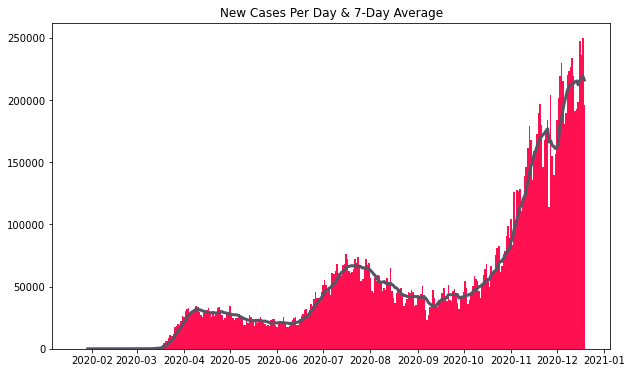

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(us_cases.Date, us_cases.New, color=RED, width=1)
ax.plot(us_cases.Date, us_cases.New7, c=GRAY, linewidth=3)
title = 'New Cases Per Day & 7-Day Average'
plt.title(title)
plt.show()

### 📈 Discrete Change of New Cases (Discrete Derivative)

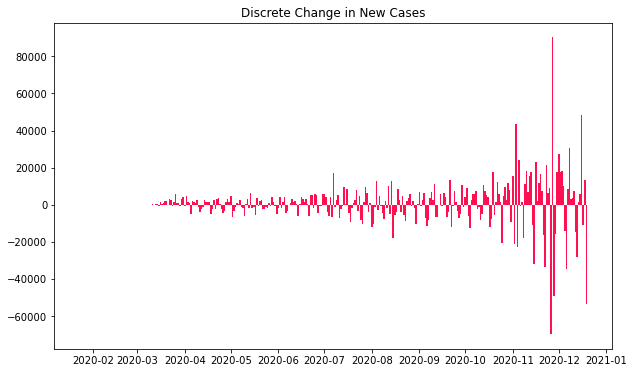

In [86]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.bar(us_cases.Date, us_cases.Change, color=RED, width=1)
ax1.title.set_text('Discrete Change in New Cases')
plt.show()

## Applying Savitzky-Golay Filter

In [87]:
cases = us_cases.Cases.values
new_cases = cases[1:] - cases[:-1]
smoothened_new_cases = savgol_filter(new_cases, 21, 3)

change_in_new_cases = smoothened_new_cases[1:] - smoothened_new_cases[:-1]
smoothened_change_in_new_cases = savgol_filter(change_in_new_cases, 21, 3)

us_cases['SgfNew'] = np.concatenate([[np.nan], smoothened_new_cases])
us_cases['SgfChange'] = np.concatenate([[np.nan, np.nan], smoothened_change_in_new_cases])

### 📈 Comparing Before & After Applying Savitzky-Golay Filter

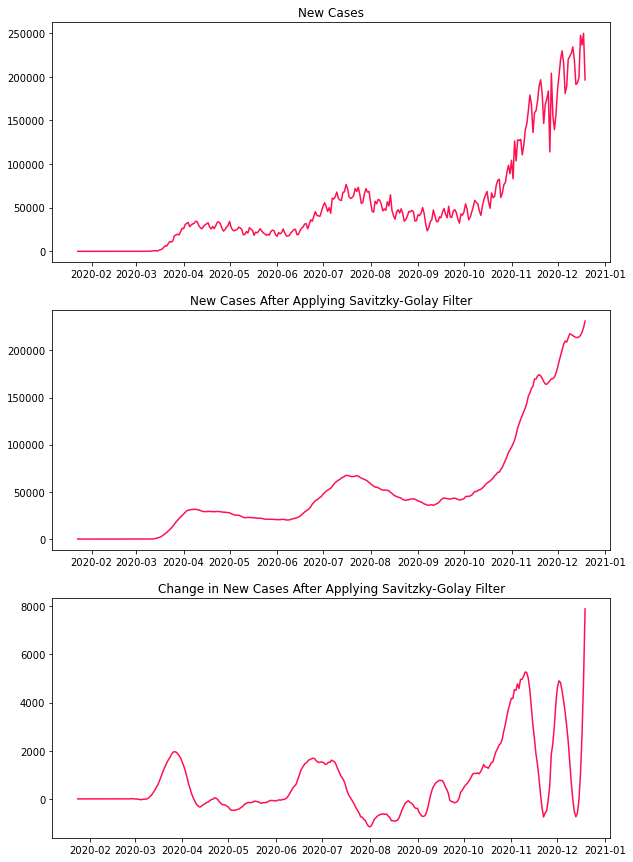

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

ax1.plot(us_cases.Date, us_cases.New, color=RED)
ax1.title.set_text('New Cases')

ax2.plot(us_cases.Date, us_cases.SgfNew, color=RED)
ax2.title.set_text('New Cases After Applying Savitzky-Golay Filter')

ax3.plot(us_cases.Date, us_cases.SgfChange, color=RED)
ax3.title.set_text('Change in New Cases After Applying Savitzky-Golay Filter')

plt.show()

## Monte-Carlo Simulation of New Cases & Change in New Cases

In [89]:
def select_with_probability(n, probability):
    return np.random.rand(n) <= probability


def select_first_and_last_value(is_selected):
    is_selected[0] = True
    is_selected[-1] = True
    return is_selected


def get_random_sample_with_probability_including_first_and_last_element(x, y, probability):
    is_selected = select_with_probability(len(x), probability)
    is_selected = select_first_and_last_value(is_selected)
    return x[is_selected], y[is_selected]
    

def linearly_interpolate(x, y, x_for_interpolation):
    interpolator = interp1d(x, y, fill_value="extrapolate")
    interpolated_y = interpolator(x_for_interpolation)
    return interpolated_y


def run_one_trial(x2, x2_as_number, raw_y2, selection_probability):
    x2_as_number_selected, raw_y2_selected = get_random_sample_with_probability_including_first_and_last_element(
        x2_as_number, raw_y2, selection_probability)
    
    raw_y2_interpolated = linearly_interpolate(x2_as_number_selected, raw_y2_selected, x2)
    
    y2_interpolated = savgol_filter(raw_y2_interpolated, 21, 3)
    
    raw_y3 = y2_interpolated[1:] - y2_interpolated[:-1]
    y3_interpolated = savgol_filter(raw_y3, 21, 3)
    
    return y2_interpolated, y3_interpolated


def run_trials(x, y, selection_probability, trials):
    x2, raw_y2 = x[1:], y[1:] - y[:-1]
    
    x2_as_number = x2.astype('int64') # avoiding problems with datetime64 type when interpolating
    
    x3 = x2[1:]

    n = len(x)
    n2 = n - 1
    n3 = n2 - 1

    y2_predicted = np.zeros([n2, trials])
    y3_predicted = np.zeros([n3, trials])

    for trial_nr in range(trials):
        y2_predicted[:, trial_nr], y3_predicted[:, trial_nr] = run_one_trial(x2, x2_as_number, raw_y2, selection_probability)
        
    return x2, x3, y2_predicted, y3_predicted


selection_probability = 1.0 / 4.0
trials = 2000

x2, x3, y2_predicted, y3_predicted = run_trials(us_cases.Date.values, us_cases.Cases.values, selection_probability, trials)

# Saving in dataframe for Plotly Chart Studio
for i in range(10):
    us_cases[f'Sim{i}New'] = np.concatenate([[np.nan], y2_predicted[:, i]])
    us_cases[f'Sim{i}Change'] = np.concatenate([[np.nan, np.nan], y3_predicted[:, i]])

### 📈 Simulated Curves with IQR

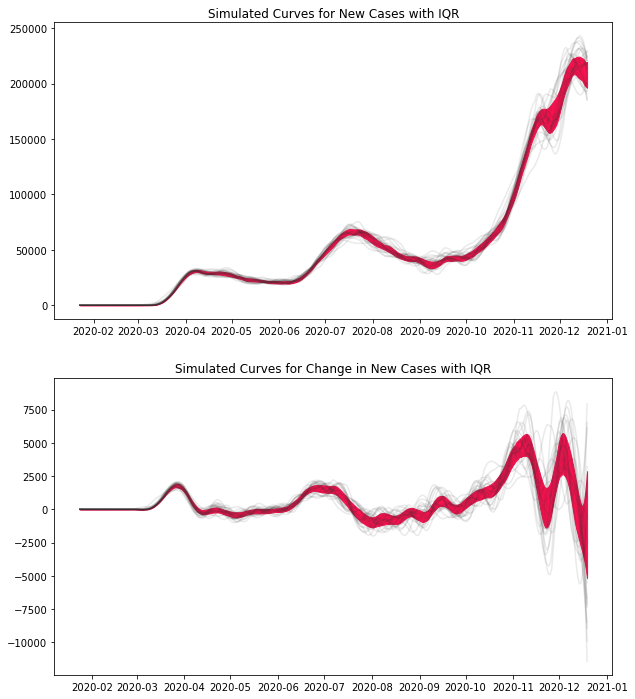

In [90]:
quantiles = [0.25, 0.75]
y2_quantiles = np.quantile(y2_predicted, quantiles, axis=1).T
y3_quantiles = np.quantile(y3_predicted, quantiles, axis=1).T

# Saving in dataframe for Plotly Chart Studio
for index, name in enumerate(['Lower', 'Upper']):
    us_cases[f'SimNewIqr{name}'] = np.concatenate([[np.nan], y2_quantiles[:, index]])
    us_cases[f'SimChangeIqr{name}'] = np.concatenate([[np.nan, np.nan], y3_quantiles[:, index]])
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.title.set_text('Simulated Curves for New Cases with IQR')
ax2.title.set_text('Simulated Curves for Change in New Cases with IQR')

for i in range(24):
    ax1.plot(x2, y2_predicted[:, i], c=(0.2, 0.2, 0.2, 0.1))
    ax2.plot(x3, y3_predicted[:, i], c=(0.2, 0.2, 0.2, 0.1))
    
ax1.fill_between(x2,y2_quantiles[:, 0], y2_quantiles[:, 1], color=RED)
ax2.fill_between(x3,y3_quantiles[:, 0], y3_quantiles[:, 1], color=RED)
plt.show()

### 📈 Show Trend

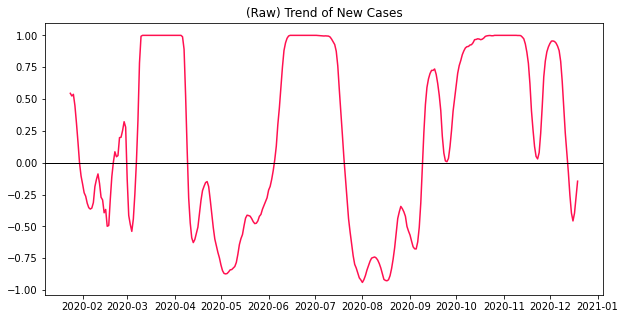

In [91]:
def get_trend(y3_predicted):
    y3_predicted_greater_or_equal_zero = (y3_predicted >= 0.0)
    trials = y3_predicted.shape[1]
    trend_dynamic = y3_predicted_greater_or_equal_zero.sum(axis=1) / trials
    trend_dynamic = (trend_dynamic * 2.0) - 1.0
    return trend_dynamic

trend = get_trend(y3_predicted)
us_cases['Trend'] = np.concatenate([[np.nan, np.nan], trend])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(us_cases.Date, us_cases.Trend, c=RED)
ax.axhline(0, c='black', linewidth=1)
ax.title.set_text('(Raw) Trend of New Cases')
plt.show()

## Save Analysis for Plotly

In [92]:
export_for_plotly(us_cases, 'total_confirmed_cases_per_day')

## Create Color Gradient for Trend Arrows

In [93]:
cmap = LinearSegmentedColormap.from_list('red_gray_blue', [RED, GRAY, BLUE], N=256)


def rgba_to_hex(rgba):
    r, g, b, a = round(rgba[0] * 255.0), round(rgba[1] * 255.0), round(rgba[2] * 255.0), round(rgba[3] * 255.0)
    return f"#{r:02x}{g:02x}{b:02x}{a:02x}"


def get_color(value):
    rgba = cmap(value)
    return rgba_to_hex(rgba)


def create_pixel_line(value):
    color = get_color(value)
    return f"""<div style="margin:0;padding:0;background-color:{color};width:50px;height:1px;display:block;overflow:hidden;">&nbsp;</div>"""


# Test output of gradient
pixel_lines = [create_pixel_line(value/50.0) for value in range(50)]
display(HTML(''.join(pixel_lines)))

## Generator for Trend Arrows

In [94]:
def clip(value):
    if value < 0.0:
        return 0.0
    if value > 1.0:
        return 1.0
    return value


def get_angle(value):
    '''
      0 => up
     90 => right
    180 => down
    '''
    value = clip(value)
    return value * 180.0


def create_arrow(value):
    angle = get_angle(value)
    color = get_color(value)
    
    return f"""
    <div style="margin:1px;padding:0px;overflow:hidden;">
        <svg style="margin:0;padding:0;" viewBox="-5 -9 10 12" width="20" height="20" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
          <g fill="{color}" transform="rotate({angle:.2f} 0 -3)">
            <path d="M 0,0 L 4,0 L 0,-9 L-4,0 L0,0 z" />
          </g>
        </svg>
    </div>
    """

# Test output of arrows
example_values = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
svg_arrows = [create_arrow(value) for value in example_values]
display(HTML(f"""
<div style="display:flex;margin-top:1rem;margin-bottom:1rem;justify-content: space-around;width:300px;">
  {''.join(svg_arrows)}
</div>
<h6>Example of arrows for values {example_values}</h6>
"""))

## Functions to Embed Figure Directly into HTML

In [95]:
def get_base64_encoded_file(filepath):
    with open(filepath, 'rb') as f:
        content = f.read()
        base64_encoded_content = base64.encodebytes(content)
        return base64_encoded_content.decode('utf-8')


def get_base64_encoded_image_from_fig(fig, format):
    image_buffer = io.BytesIO()
    fig.savefig(image_buffer, format=format)
    plt.close(fig)
    image_buffer.seek(0)
    image_data = image_buffer.read()
    base64_encoded_image_data = base64.encodebytes(image_data)
    return base64_encoded_image_data.decode('utf-8')


def get_base64_encoded_image_tag_of_fig(fig):
    base64_encoded_png = get_base64_encoded_image_from_fig(fig, 'png')
    return f"""<img src='data:image/png;base64,{base64_encoded_png}' />"""


# Test Saving and Base64 Encoding of Figure
fig, ax = plt.subplots(1,1, figsize=(3,2))
x, y = np.random.randn(100), np.random.randn(100)
ax.scatter(x, y, c=y, cmap=cmap)
display(HTML(get_base64_encoded_image_tag_of_fig(fig) + '<h6>Example of image (tag) with base64-encoded content</h6>'))

## Trend Analysis for Countries

In [96]:
def get_trend_from_data(x, y, selection_probability, trials):
    x2, x3, y2_predicted, y3_predicted = run_trials(x, y, selection_probability, trials)
    return get_trend(y3_predicted)


def get_raw_data_for_country(country, cases_by_date_and_country):
    cases_by_date = cases_by_date_and_country[ cases_by_date_and_country['Country/Region'] == country ].copy()
    cases_by_date.reset_index(inplace=True)
    return cases_by_date.Date.values, cases_by_date.Cases.values
    

def compute_country_trend_data(country, cases_by_date_and_country, selection_probability, trials):
    x, y = get_raw_data_for_country(country, cases_by_date_and_country)

    trend = get_trend_from_data(x, y, selection_probability, trials)
        
    return {
        'country': country,
        'x': x,
        'y': y,
        'trend': trend
    }


def compute_countries_trend_data(countries, cases_by_date_and_country, selection_probability, trials):
    countries_trend_data = []
    
    tqdm_bar = tqdm(countries)
    for country in tqdm_bar:
        tqdm_bar.set_postfix({'Country': country})
        country_trend_data = compute_country_trend_data(country, cases_by_date_and_country, selection_probability, trials)
        countries_trend_data.append(country_trend_data)
    
    return countries_trend_data


selection_probability = 1.0 / 4.0
trials = 2000

countries_trend_data = compute_countries_trend_data(COUNTRIES_FOR_REPORT, cases_by_date_and_country, selection_probability, trials)

100%|██████████| 14/14 [00:21<00:00,  1.53s/it, Country=Switzerland]  


## 📈 Show Trend Report

In [97]:
def create_mini_plot(country_trend_data):
    x, y = country_trend_data['x'], country_trend_data['y']
    
    x2, raw_y2 = x[1:], y[1:] - y[:-1]
    y2 = savgol_filter(raw_y2, 21, 3)

    fig, ax = plt.subplots(1, 1, figsize=(1, 0.35))
    ax.plot(x2, y2, c='grey')
    ax.set_axis_off()
    ax.margins(0.01)
    
    return get_base64_encoded_image_tag_of_fig(fig)


def create_trend_arrow(country_trend_data):
    latest_trend = country_trend_data['trend'][-1]
    arrow_value = 1.0 - ((latest_trend + 1.0) / 2.0)
    svg_of_arrow = create_arrow(arrow_value)
    return svg_of_arrow

    
def save_and_display_html(filepath, content, iframe_height):
    with open(filepath, 'w') as f:
        f.write(content)
    display(IFrame(src=filepath, width='100%', height=iframe_height))


def create_tr_from_country_trend_data(country_trend_data):
    img_of_plot = create_mini_plot(country_trend_data)
    svg_of_arrow = create_trend_arrow(country_trend_data)
    country = country_trend_data['country']
    
    return f"""
    <tr>
        <td style="text-align:left;">{country}</td>
        <td style="text-align:center;">{img_of_plot}</td>
        <td style="text-align:center;">{svg_of_arrow}</td>
    </tr>
    """.strip()


def sort_countries_trend_data(countries_trend_data):
    def key_sorter(country_trend_data):
        return -country_trend_data['trend'][-1]
    
    return sorted(countries_trend_data, key=key_sorter) 


def create_trend_table(countries_trend_data):
    sorted_countries_trend_data = sort_countries_trend_data(countries_trend_data)
    
    tr = ""
    for country_trend_data in sorted_countries_trend_data:
        tr += create_tr_from_country_trend_data(country_trend_data)
        
    return f"""
        <table class="table table-sm" style="">
            <thead>
                <tr><th>Country</th><th class="text-center">New Cases</th><th class="text-center">Trend</th></tr>
            </thead>
            <tbody>
                {tr}
            </tbody>
        </table>
    """.strip()
    

def get_current_date():
    return datetime.datetime.now().strftime('%d.%m.%Y')


def create_trend_report(countries_trend_data):
    table = create_trend_table(countries_trend_data)
    report_date = get_current_date()
    return f"""
        <!DOCTYPE html>
        <html>
        <head>
            <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@4.5.3/dist/css/bootstrap.min.css" integrity="sha384-TX8t27EcRE3e/ihU7zmQxVncDAy5uIKz4rEkgIXeMed4M0jlfIDPvg6uqKI2xXr2" crossorigin="anonymous">
            <script src="https://code.jquery.com/jquery-3.5.1.slim.min.js" integrity="sha384-DfXdz2htPH0lsSSs5nCTpuj/zy4C+OGpamoFVy38MVBnE+IbbVYUew+OrCXaRkfj" crossorigin="anonymous"></script>
            <script src="https://cdn.jsdelivr.net/npm/bootstrap@4.5.3/dist/js/bootstrap.bundle.min.js" integrity="sha384-ho+j7jyWK8fNQe+A12Hb8AhRq26LrZ/JpcUGGOn+Y7RsweNrtN/tE3MoK7ZeZDyx" crossorigin="anonymous"></script>
            <title>Covid-19 Trend Report</title>
        </head>
        <body class="p-5">
            <div class="container">
                <div class="row justify-content-center">
                    <div class="col-11 col-lg-8">
                        <div class="jumbotron">
                          <h1 class="display-4">Covid-19 Trend Report</h1>
                          <p class="lead">{report_date}</p>
                          <hr>
                          <p>Shows the country, the number of new cases per day, and a trend indicating the dynamic of the increase/decrease of new cases.</p>
                          <p class="lead text-right">
                            <a class="btn btn-secondary btn-small" href="https://github.com/tobiaskaechele/Covid-19-Trend-Report" role="button">More Info</a>
                          </p>
                        </div>
                    </div>
                    <div class="col-11 col-lg-4">
                        {table}
                    </div>
                </div>
            </div>
        </body>
        </html>
        """.strip()
    

def create_and_display_trend_report(filepath, countries_trend_data, iframe_height):
    report = create_trend_report(countries_trend_data)
    save_and_display_html(filepath, report, iframe_height)
    

report_filepath = get_output_filepath('report.htm')
create_and_display_trend_report(report_filepath, countries_trend_data, iframe_height=700)